In [3]:
import matplotlib.pyplot as plt
from custom_scalar_formatter import CustomScalarFormatter
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import os

In [4]:
def load_sensitivity_results(results_dir, dataset, opt, n_runs, hyperparam):
    results = {}

    optimizer = opt['optimizer']
    preconditioner = opt['precond']
    results_dir = os.path.join(results_dir, dataset, optimizer, preconditioner)

    for i in range(1, n_runs+1):
        results_dir_run = os.path.join(results_dir, 'run_' + str(i))
        filenames = os.listdir(results_dir_run)

        for filename in filenames:
            if filename.endswith('.csv'):
                u = filename.split('_')[1]
                r = filename.split('_')[3]
                if hyperparam == 'update_freq':
                    hyperparam_outer = u
                    hyperparam_inner = r
                elif hyperparam == 'rank':
                    hyperparam_outer = r
                    hyperparam_inner = u

                # print(filename)
                # print('hyperparam_outer: {}, hyperparam_inner: {}'.format(hyperparam_outer, hyperparam_inner))
                    
                df = pd.read_csv(os.path.join(results_dir_run, filename))
                if hyperparam_outer not in list(results.keys()):
                    results[hyperparam_outer] = {}
                    # print(list(results[hyperparam_outer].keys()))
                if hyperparam_inner not in list(results[hyperparam_outer].keys()):
                    results[hyperparam_outer][hyperparam_inner] = []
                    # print('Adding hyperparam_outer: {}, hyperparam_inner: {}'.format(hyperparam_outer, hyperparam_inner))
                    # print(list(results[hyperparam_outer].keys()))
                results[hyperparam_outer][hyperparam_inner].append(df)
    return results

In [5]:
def compute_median_quantiles(opt_results, q_lower = 0.1, q_upper = 0.9):
    median = {}
    ql = {}
    qu = {}
    for hyperparam_outer in list(opt_results.keys()):
        median[hyperparam_outer] = {}
        ql[hyperparam_outer] = {}
        qu[hyperparam_outer] = {}
        for hyperparam_inner in list(opt_results[hyperparam_outer].keys()):
            median[hyperparam_outer][hyperparam_inner] = {}
            ql[hyperparam_outer][hyperparam_inner] = {}
            qu[hyperparam_outer][hyperparam_inner] = {}
            n = len(opt_results[hyperparam_outer][hyperparam_inner])
            data_cols = list(opt_results[hyperparam_outer][hyperparam_inner][0].columns[1:]) # Get column names
            n_data_rows = len(opt_results[hyperparam_outer][hyperparam_inner][0]) # Number of rows in the data
            for metric in data_cols:
                if metric in ['times', 'train_loss', 'test_loss', 'train_acc', 'test_acc']: # Compute median for these metrics
                    metric_data = np.zeros((n_data_rows, n))
                    for i in range(n):
                        metric_data[:, i] = opt_results[hyperparam_outer][hyperparam_inner][i][metric].to_numpy()
                        metric_data[:, i] = np.nan_to_num(metric_data[:, i], nan = np.inf)
                    if metric not in list(median[hyperparam_outer][hyperparam_inner].keys()):
                        median[hyperparam_outer][hyperparam_inner][metric] = np.median(metric_data, axis = 1)
                        ql[hyperparam_outer][hyperparam_inner][metric] = np.quantile(metric_data, q_lower, axis = 1)
                        qu[hyperparam_outer][hyperparam_inner][metric] = np.quantile(metric_data, q_upper, axis = 1)

    return {'median': median, 'ql': ql, 'qu': qu}

In [6]:
def get_hyperparam_label(hyperparam, hyperparam_inner):
    if hyperparam == '100000.0': # Hardcoded for now
        hyperparam_label = '$\infty$'
    else:
        hyperparam_label = hyperparam

    if hyperparam_inner == 'update_freq':
        hyperparam_label = f'u = {hyperparam_label}'
    elif hyperparam_inner == 'rank':
        hyperparam_label = f'r = {hyperparam_label}'

    return hyperparam_label

In [7]:
def plot_hyperparam_curve(results, hyperparam_val, hyperparam, hyperparam_label, xaxis, metric, axes):
    if xaxis['name'] == 'time':
        x = np.cumsum(results['median'][hyperparam_val][hyperparam]['times'])
    elif xaxis['name'] == 'epochs':
        x = np.arange(len(results['median'][hyperparam_val][hyperparam]['times'])) + 1

    if 'loss' in metric['name']:
        axes.semilogy(x, 
                results['median'][hyperparam_val][hyperparam][metric['name']], 
                label = hyperparam_label)
    else:
        axes.plot(x, 
                results['median'][hyperparam_val][hyperparam][metric['name']], 
                label = hyperparam_label)

In [8]:
def format_plot(dataset, ylims, xaxis, metric, axes):
    axes.set_title(dataset, fontsize=14)
    axes.set_ylim(ylims)

    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.tick_params(axis='both', which='minor', labelsize=10)
    axes.set_xlabel(xaxis['label'], fontsize=14)
    axes.set_ylabel(metric['label'], fontsize=14)

    if 'loss' in metric['name']:
        y_lower_bound, y_upper_bound = axes.get_ylim()
        axes.set_yticks([y_lower_bound, y_upper_bound])

        formatter = CustomScalarFormatter(useMathText=True, useOffset=False)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))
        axes.yaxis.set_major_formatter(formatter)

        minor_ticks = np.linspace(y_lower_bound, y_upper_bound, num=10)
        minor_ticks = minor_ticks[1:-1]
        axes.set_yticks(minor_ticks, minor=True)
        # axes.yaxis.set_minor_formatter(formatter)
        axes.yaxis.set_minor_formatter(NullFormatter())

In [9]:
def save(directory, fig_name, fig):
    plt.figure(fig)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(os.path.join(directory, fig_name), bbox_inches='tight')

In [10]:
def plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, 
                        hyperparam_val, hyperparam_inner, metric, xaxis, ylims, save_plot = True):
    results = load_sensitivity_results(results_dir, dataset, opt, n_runs, hyperparam_outer)
    results = compute_median_quantiles(results)

    keys_inner = list(results['median'][hyperparam_val].keys())
    keys_inner_numeric = [float(key) for key in keys_inner]
    keys_inner_sorted = [x for _, x in sorted(zip(keys_inner_numeric, keys_inner))]

    fig = plt.figure()
    axes = plt.gca()
    for hyperparam in keys_inner_sorted:
        hyperparam_label = get_hyperparam_label(hyperparam, hyperparam_inner)

        if hyperparam_inner == 'rank' and float(hyperparam) > 50:
            continue
        else:
            plot_hyperparam_curve(results, hyperparam_val, hyperparam, hyperparam_label, xaxis, metric, axes)
    
    axes.legend(loc='upper right', ncol=2, fontsize=14)
    format_plot(dataset, ylims, xaxis, metric, axes)

    if save_plot:
        fig_name = f"{dataset}_" + ('r' if hyperparam_inner == 'rank' else 'u') + '.pdf'
        directory = './sensitivity'
        save(directory, fig_name, fig)

In [11]:
def plot_medians_metric_datasets_xaxes(results_dir, data_params, xaxes, opt, hyperparam_outer,
                                        hyperparam_val, hyperparam_inner, metric):
    # each element of data_params is dictionary with keys 'dataset', 'n_runs', 'ylims'
    # Create a grid of plots, one for each dataset and x-axis
    n_datasets = len(data_params)
    n_xaxes = len(xaxes)
    fig, axes = plt.subplots(nrows = n_xaxes, ncols = n_datasets, figsize = (n_datasets*4, n_xaxes*4))
    
    dataset_concatenated = ''

    for i, data_param in enumerate(data_params):
        dataset = data_param['dataset']
        dataset_name = data_param['name']
        n_runs = data_param['n_runs']
        ylims = data_param['ylims']
        dataset_concatenated += dataset + '_' # For saving the figure
        for j, xaxis in enumerate(xaxes):
            subplot_idx = j * n_xaxes + i

            results = load_sensitivity_results(results_dir, dataset, opt, n_runs, hyperparam_outer)
            results = compute_median_quantiles(results)

            keys_inner = list(results['median'][hyperparam_val].keys())
            keys_inner_numeric = [float(key) for key in keys_inner]
            keys_inner_sorted = [x for _, x in sorted(zip(keys_inner_numeric, keys_inner))]

            for hyperparam in keys_inner_sorted:
                hyperparam_label = get_hyperparam_label(hyperparam, hyperparam_inner)
                
                if hyperparam_inner == 'rank' and float(hyperparam) > 50: # Filter out ranks > 50 for plotting purposes
                    continue
                else:
                    plot_hyperparam_curve(results, hyperparam_val, hyperparam, hyperparam_label, xaxis, metric, axes.flat[subplot_idx])

            format_plot(dataset_name, ylims, xaxis, metric, axes.flat[subplot_idx])

    for ax in axes.flat:
        ax.set_ylabel('') # Turn off y-labels for subplots
    fig.text(0, 0.5, metric['label'], va='center', rotation='vertical', fontsize=14)

    fig.tight_layout(pad=2.0)

    # Add legend to the bottom of the grid
    num_entries = len(axes.flat[0].get_legend_handles_labels()[1])
    fig.legend(handles=axes.flat[0].get_legend_handles_labels()[0], 
           labels=axes.flat[0].get_legend_handles_labels()[1], loc = 'upper center', bbox_to_anchor = (0.5, 0.0), ncol = num_entries, fontsize=14)

    # Save plot
    directory = './sensitivity'
    fig_name = f"combined_{dataset_concatenated}" + ('r' if hyperparam_inner == 'rank' else 'u') + '.pdf'
    save(directory, fig_name, fig)

In [12]:
results_dir = '../simods_sensitivity_results'
opt = {'optimizer': 'sketchysgd', 'precond': 'nystrom'}
metrics = [{'name': 'train_loss', 'label': 'Training Loss'},
        {'name': 'test_loss', 'label': 'Test Loss'},
        {'name': 'train_acc', 'label': 'Training Accuracy (%)'},
        {'name': 'test_acc', 'label': 'Test Accuracy (%)'}]
xaxes = [{'name': 'epochs', 'label': 'Epochs'},
         {'name': 'time', 'label': 'Wall-clock time (s)'}]

In [13]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

### Combined r

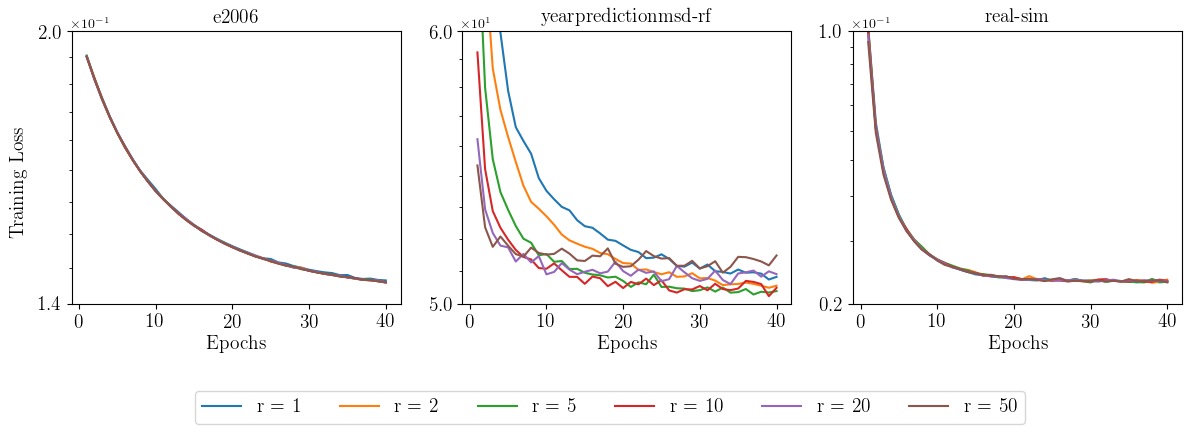

In [14]:
data_params = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 10, 'ylims': [1.4e-1, 2e-1]},
               {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 10, 'ylims': [5e1, 6e1]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [2e-2, 1e-1]}
            ]
hyperparam_outer = 'update_freq'
hyperparam_inner = 'rank'
hyperparam_val = '1.0'
plot_medians_metric_datasets_xaxes(results_dir, data_params, [xaxes[0]], opt, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0])

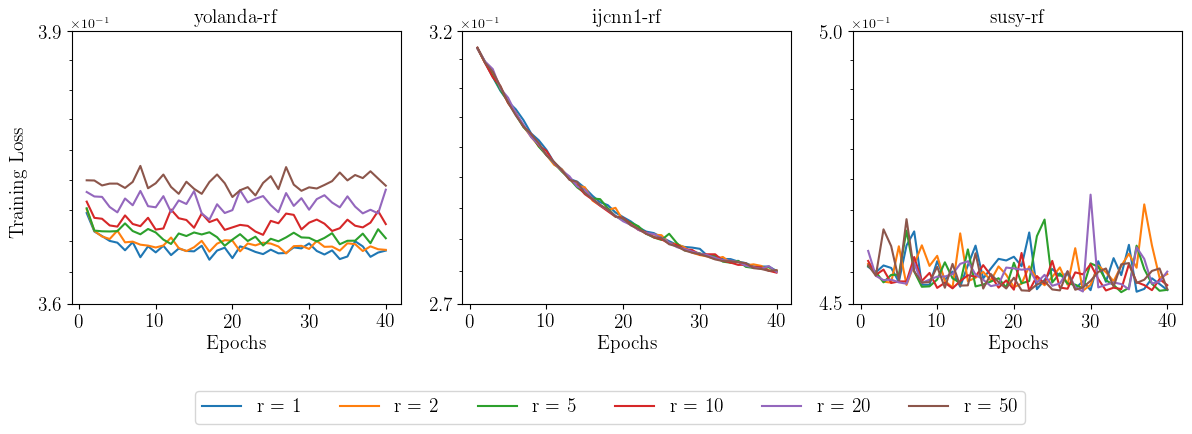

In [15]:
data_params = [{'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 10, 'ylims': [3.6e-1, 3.9e-1]},
               {'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [2.7e-1, 3.2e-1]},
               {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [4.5e-1, 5e-1]}
            ]
hyperparam_outer = 'update_freq'
hyperparam_inner = 'rank'
hyperparam_val = '1.0'
plot_medians_metric_datasets_xaxes(results_dir, data_params, [xaxes[0]], opt, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0])

### Combined u

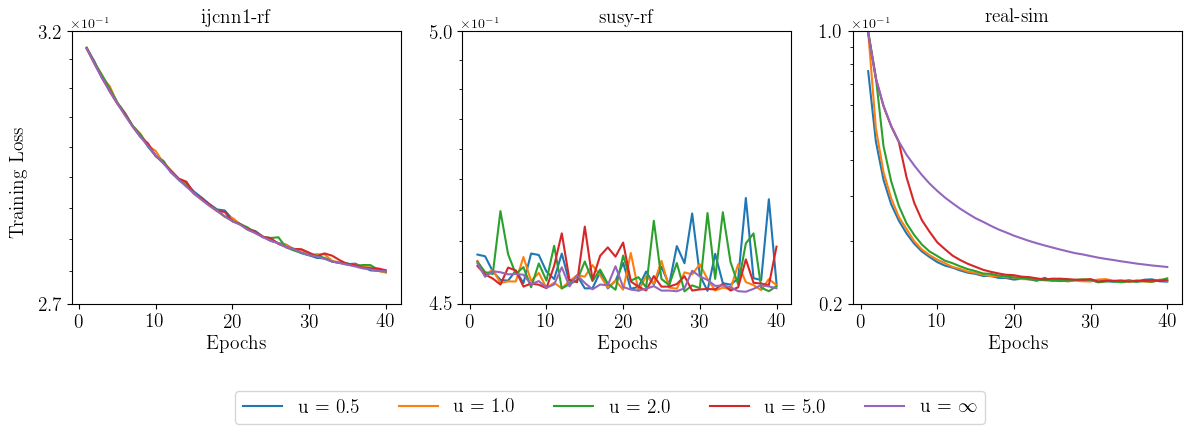

In [16]:
data_params = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [2.7e-1, 3.2e-1]},
               {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [4.5e-1, 5e-1]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [2e-2, 1e-1]}
            ]
hyperparam_outer = 'rank'
hyperparam_inner = 'update_freq'
hyperparam_val = '10'
plot_medians_metric_datasets_xaxes(results_dir, data_params, [xaxes[0]], opt, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0])

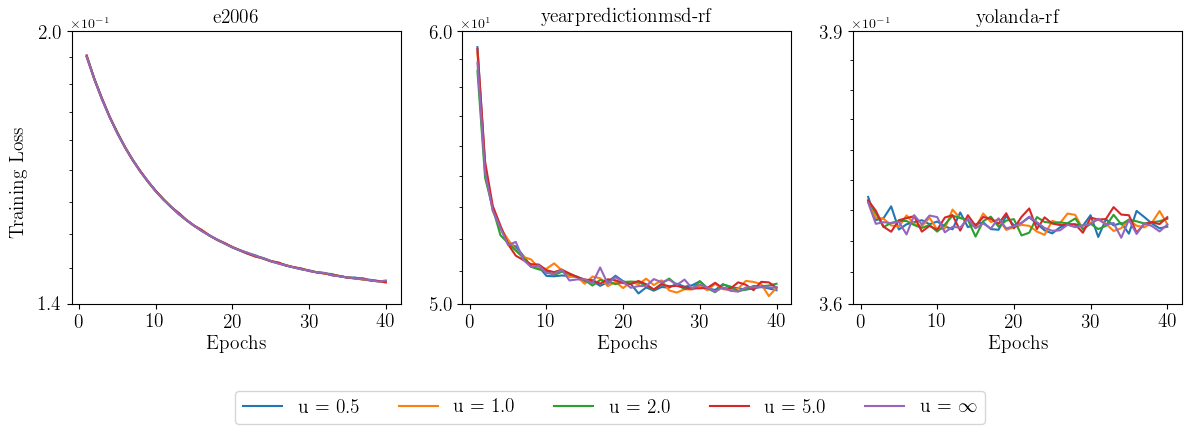

In [17]:
data_params = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 10, 'ylims': [1.4e-1, 2e-1]},
               {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 10, 'ylims': [5e1, 6e1]},
               {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 10, 'ylims': [3.6e-1, 3.9e-1]}
            ]
hyperparam_outer = 'rank'
hyperparam_inner = 'update_freq'
hyperparam_val = '10'
plot_medians_metric_datasets_xaxes(results_dir, data_params, [xaxes[0]], opt, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0])

### ijcnn1

In [18]:
# dataset = 'ijcnn1'
# n_runs = 10
# hyperparam_outer = 'update_freq'
# hyperparam_inner = 'rank'
# hyperparam_val = '1.0'
# ylims = [2.7e-1, 3.2e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

In [19]:
# dataset = 'ijcnn1'
# n_runs = 10
# hyperparam_outer = 'rank'
# hyperparam_inner = 'update_freq'
# hyperparam_val = '10'
# ylims = [2.7e-1, 3.2e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

### real-sim

In [20]:
# dataset = 'real-sim'
# n_runs = 10
# hyperparam_outer = 'update_freq'
# hyperparam_inner = 'rank'
# hyperparam_val = '1.0'
# ylims = [2e-2, 1e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

u = 0.5
u = 1.0
u = 2.0
u = 5.0
u = $\infty$
u = 0.5
u = 1.0
u = 2.0
u = 5.0
u = $\infty$


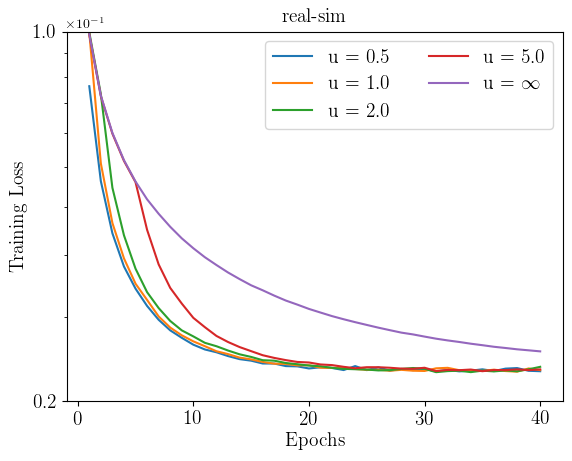

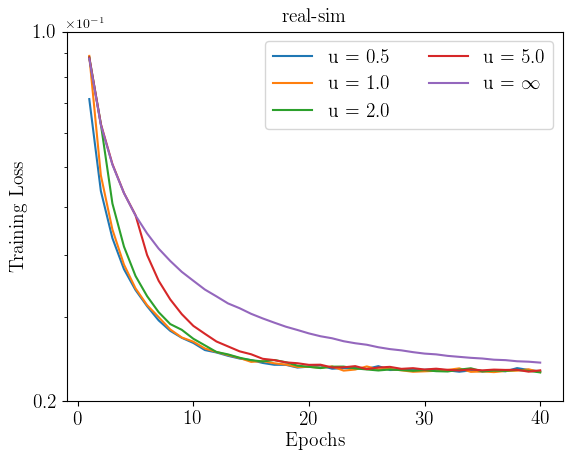

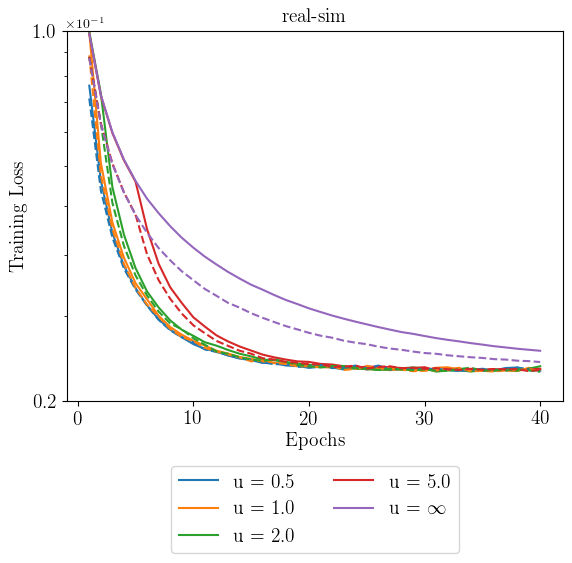

In [21]:
dataset = 'real-sim'
n_runs = 10
hyperparam_outer = 'rank'
hyperparam_inner = 'update_freq'
hyperparam_val = '10'
ylims = [2e-2, 1e-1]
plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

ax = plt.gca()
curves10 = ax.get_lines()
for curve in curves10:
    print(curve.get_label())

dataset = 'real-sim'
n_runs = 10
hyperparam_outer = 'rank'
hyperparam_inner = 'update_freq'
hyperparam_val = '240'
ylims = [2e-2, 1e-1]
plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims, save_plot = False)

ax = plt.gca()
curves240 = ax.get_lines()
for curve in curves240:
    print(curve.get_label())

colors = {'u = 0.5': 'tab:blue', 'u = 1.0': 'tab:orange', 'u = 2.0': 'tab:green', 'u = 5.0': 'tab:red', 'u = $\infty$': 'tab:purple'}

# Plot both curves on the same plot
fig, ax = plt.subplots()
for curve in curves10:
    ax.semilogy(curve.get_xdata(), curve.get_ydata(), label=curve.get_label(), color=colors[curve.get_label()])
for curve in curves240:
    ax.semilogy(curve.get_xdata(), curve.get_ydata(), linestyle='--', color=colors[curve.get_label()])

plt.legend(loc='upper center', bbox_to_anchor = (0.5, -0.15), ncol=2, fontsize=14)
plt.title('real-sim', fontsize=14)
plt.ylim([2e-2, 1e-1])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Training Loss', fontsize=14)

y_lower_bound, y_upper_bound = ax.get_ylim()
ax.set_yticks([y_lower_bound, y_upper_bound])

formatter = CustomScalarFormatter(useMathText=True, useOffset=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(formatter)

minor_ticks = np.linspace(y_lower_bound, y_upper_bound, num=10)
minor_ticks = minor_ticks[1:-1]
ax.set_yticks(minor_ticks, minor=True)
ax.yaxis.set_minor_formatter(NullFormatter())

plt.savefig('./sensitivity/real-sim_u_multiple_r.pdf', bbox_inches='tight')

### susy

In [22]:
# dataset = 'susy'
# n_runs = 3
# hyperparam_outer = 'update_freq'
# hyperparam_inner = 'rank'
# hyperparam_val = '1.0'
# ylims = [4.5e-1, 5e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

In [23]:
# dataset = 'susy'
# n_runs = 3
# hyperparam_outer = 'rank'
# hyperparam_inner = 'update_freq'
# hyperparam_val = '10'
# ylims = [4.5e-1, 5e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

### e2006

In [24]:
# dataset = 'e2006'
# n_runs = 10
# hyperparam_outer = 'update_freq'
# hyperparam_inner = 'rank'
# hyperparam_val = '1.0'
# ylims = [1.4e-1, 2e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

In [25]:
# dataset = 'e2006'
# n_runs = 10
# hyperparam_outer = 'rank'
# hyperparam_inner = 'update_freq'
# hyperparam_val = '10'
# ylims = [1.4e-1, 2e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

### yearpredictionmsd

In [26]:
# dataset = 'yearpredictionmsd'
# n_runs = 10
# hyperparam_outer = 'update_freq'
# hyperparam_inner = 'rank'
# hyperparam_val = '1.0'
# ylims = [5e1, 6e1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

In [27]:
# dataset = 'yearpredictionmsd'
# n_runs = 10
# hyperparam_outer = 'rank'
# hyperparam_inner = 'update_freq'
# hyperparam_val = '10'
# ylims = [5e1, 6e1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

### yolanda

In [28]:
# dataset = 'yolanda'
# n_runs = 10
# hyperparam_outer = 'update_freq'
# hyperparam_inner = 'rank'
# hyperparam_val = '1.0'
# ylims = [3.6e-1, 3.9e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)

In [29]:
# dataset = 'yolanda'
# n_runs = 10
# hyperparam_outer = 'rank'
# hyperparam_inner = 'update_freq'
# hyperparam_val = '10'
# ylims = [3.6e-1, 3.9e-1]
# plot_medians_metric(results_dir, dataset, opt, n_runs, hyperparam_outer, hyperparam_val, hyperparam_inner, metrics[0], xaxes[0], ylims)